**Цель ноутбука:** понять как выглядят данные и получить ответы на следующие вопросы:

    1. Как распределен таргет?
    2. Как распределена энергия внутри молекул?
    3. Как отличаются train/test/private?
    4. Как перевести данные в другой формат?

In [1]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from pymatgen.core import Structure

from pymatgen.io.jarvis import JarvisAtomsAdaptor
from sklearn.cluster import KMeans

plt.rcParams["figure.dpi"] = 70
plt.rcParams["figure.figsize"] = (10, 5)


In [2]:
def read_json_structures(root: Path) -> pd.DataFrame:
    return pd.DataFrame([
        {'_id': path.name.strip('.json'), 'structure': Structure.from_dict(json.load(open(path)))}
        for path in tqdm(root.glob('*.json'))
    ])


In [3]:
root_public_path = Path('../data/dichalcogenides_public')
df_publ = read_json_structures(
    root_public_path / 'structures'
).merge(pd.read_csv(root_public_path / 'targets.csv'))

# понадобится дальше
df_publ['formula'] = df_publ['structure'].apply(lambda x: x.formula)


2966it [00:20, 148.07it/s]


### Как перевести данные в другой формат

#### pymatgen -> jarvis

In [4]:
structure = df_publ.sample(1).iloc[0]
jarvis_obj = JarvisAtomsAdaptor().get_atoms(structure['structure'])


#### jarvis to file

In [5]:
!mkdir 'eda_export'
jarvis_obj.write_cif('eda_export' / Path(structure['_id']).with_suffix('.cif'))
jarvis_obj.write_xyz('eda_export' / Path(structure['_id']).with_suffix('.xyz'))
jarvis_obj.write_poscar('eda_export' / Path(structure['_id']).with_suffix('.poscar'))


mkdir: eda_export: File exists


### Как распределен таргет?

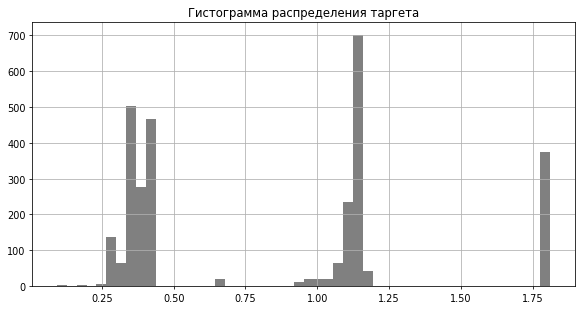

In [6]:
ax = df_publ['band_gap'].hist(bins=50, color='grey')
ax.set_title('Гистограмма распределения таргета')


**Вывод**: наблюдается явный дисбаланс представителей материалов различных band gapов. Посмотрим на координаты центроид бэнд гэпов.

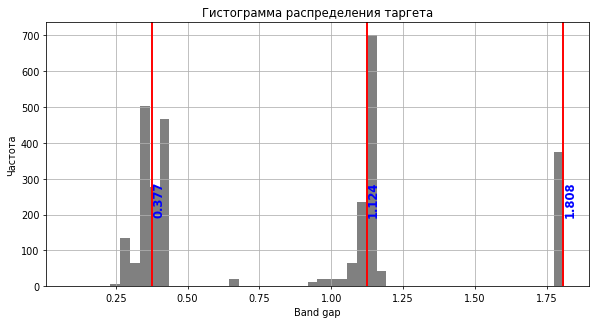

In [7]:
kmeans = KMeans(n_clusters=3).fit(df_publ['band_gap'].values.reshape(-1, 1))

ax = df_publ['band_gap'].hist(bins=50, color='grey')
ax.set_title('Гистограмма распределения таргета')
ax.set_xlabel('Band gap')
ax.set_ylabel('Частота')

for center in kmeans.cluster_centers_:
    ax.axvline(center, color='red', linewidth=2)
    ax.text(center, 200,  round(center[0], 3), rotation=90, weight='bold', size=12, color='blue')


**Вывод**: наблюдаем дисбаланс в представителях энергии, скопленный вокруг координат 0.377, 1.124, 1.808

Какой энергии вообще не представлено в выборке?

Text(0, 0.5, '=1 если энергия есть в выборке, =0, если нет')

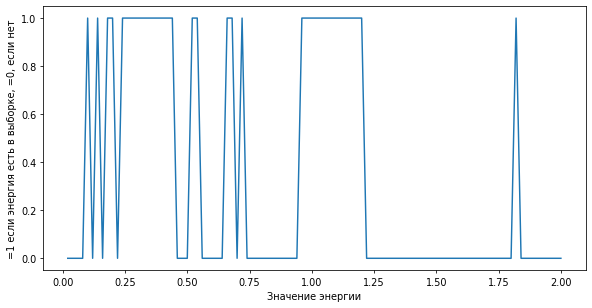

In [26]:
hist, edges = np.histogram(df_publ['band_gap'], bins=100, range=(0, 2), density=False)
plt.plot(edges[1:], np.where(hist > 0, 1, 0))
plt.xlabel('Значение энергии')
plt.ylabel('=1 если энергия есть в выборке, =0, если нет')


#### Связь молекул с таргетами

Какие молекулы присутсвуют в трейне и в каком количестве?

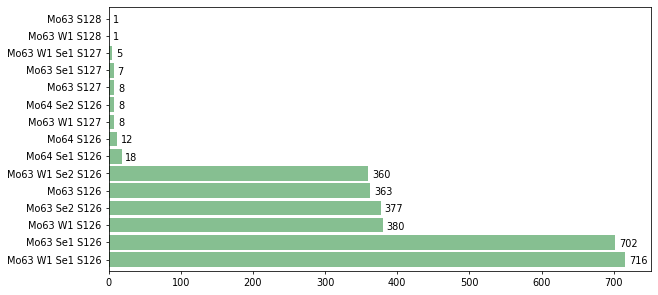

In [53]:
ax = df_publ['formula'].value_counts().plot.barh(color='#86bf91', zorder=2, width=0.85)

for n, (_, value) in enumerate(df_publ['formula'].value_counts().items()):
    ax.text(value + 5, n - 0.25, str(value))


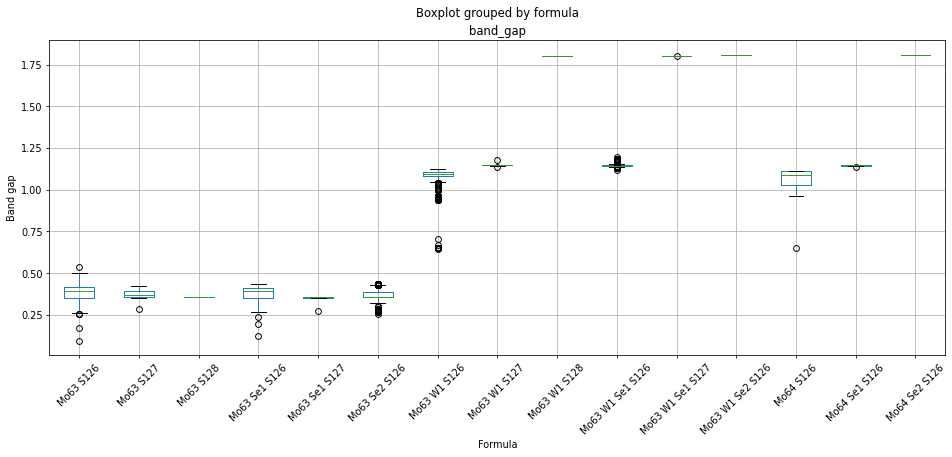

In [71]:
ax = df_publ.boxplot(column=['band_gap'], by=['formula'], figsize=(16, 6))
ax.set_xlabel('Formula')
ax.set_ylabel('Band gap')
plt.xticks(rotation=45)
